# Backcasting Demo Notebook

_Loren Champlin_

Adapted from _Adarsh Pyarelal_'s WM 12 Month Evaluation Notebook 

As always, we begin with imports, and print out the commit hash for a rendered
version of the notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from delphi.visualization import visualize
import delphi.jupyter_tools as jt
import numpy as np
import pandas as pd
from delphi.db import engine
jt.print_commit_hash_message()
import random as rm
import delphi.evaluation as EN
import delphi.AnalysisGraph as AG
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.CRITICAL)

This notebook has been rendered with commit b'01b6672d1ff84a8cc024b087e69d880a5a42f444' of Delphi.


Here I will set random seeds

In [2]:
np.random.seed(87)
rm.seed(87)

Now we load the Causal Analysis Graph (CAG). This is CAG was inferred by reading in a JSON corpus and was pruned and adjusted to be human migration centered. Also is a list of the nodes contained in the CAG

In [3]:
with open("../scripts/build/migration_centered_CAG.pkl",'rb') as f:
    G = pickle.load(f)

for n in G.nodes:
    print(n)

UN/events/human/economic_crisis
UN/events/human/famine
UN/entities/human/financial/economic/import
UN/interventions/peacekeeping_and_security
UN/events/human/conflict
UN/entities/natural/livestock
UN/events/human/human_migration
UN/entities/human/food/food_security
UN/entities/human/financial/economic/market
UN/events/human/political/political_instability


Next we map indicator variables to nodes. For the most part indicator variables can be inferred from available data and texts, but we can also manually map indicators to nodes.

In [4]:
G.map_concepts_to_indicators()

G.set_indicator("UN/events/human/human_migration", "New asylum seeking applicants", "UNHCR")
G.set_indicator("UN/entities/human/financial/economic/market", "Inflation Rate", "ieconomics.com")
G.set_indicator("UN/entities/human/food/food_security", "IPC Phase Classification", "FEWSNET")
G.set_indicator("UN/interventions/peacekeeping_and_security", "Presence of peace keepers","WDI")

Here is also a list of the indicator variables in the same order as the list of nodes above (i.e "Claims on other sectors of the domestic economy" is attached to "UN/events/human/economic_crisis"
                                                                                              
                                                                                              

In [5]:
for n in G.nodes(data=True):
    for indicators in n[1]["indicators"].values():
        print(indicators.name)

Claims on other sectors of the domestic economy
Percentage of cattle loss accounted for by starvation
Import Value, Forest products (export/import)
Presence of peace keepers
Conflict incidences
Production, Meat, cattle
New asylum seeking applicants
IPC Phase Classification
Inflation Rate
Value, Political stability and absence of violence/terrorism (index)


In the cell below, we visualize the CAG parameterized with indicator values for January, 2012. Also note that you can specifiy units for a particular indicator variables using a dictionary object where the keys are the indicator variable names and the values are the specified units. Default units are used if the selected units for an indicator variable do not exist. 

Legend for visualization: 
- Red edge: overall inhibition, green edge: overall promotion
- Edge thickness corresponds roughly to the 'strength' of the influence.
- Edge opacity corresponds roughly to the number of evidence fragments 
  that support the causal relationship.

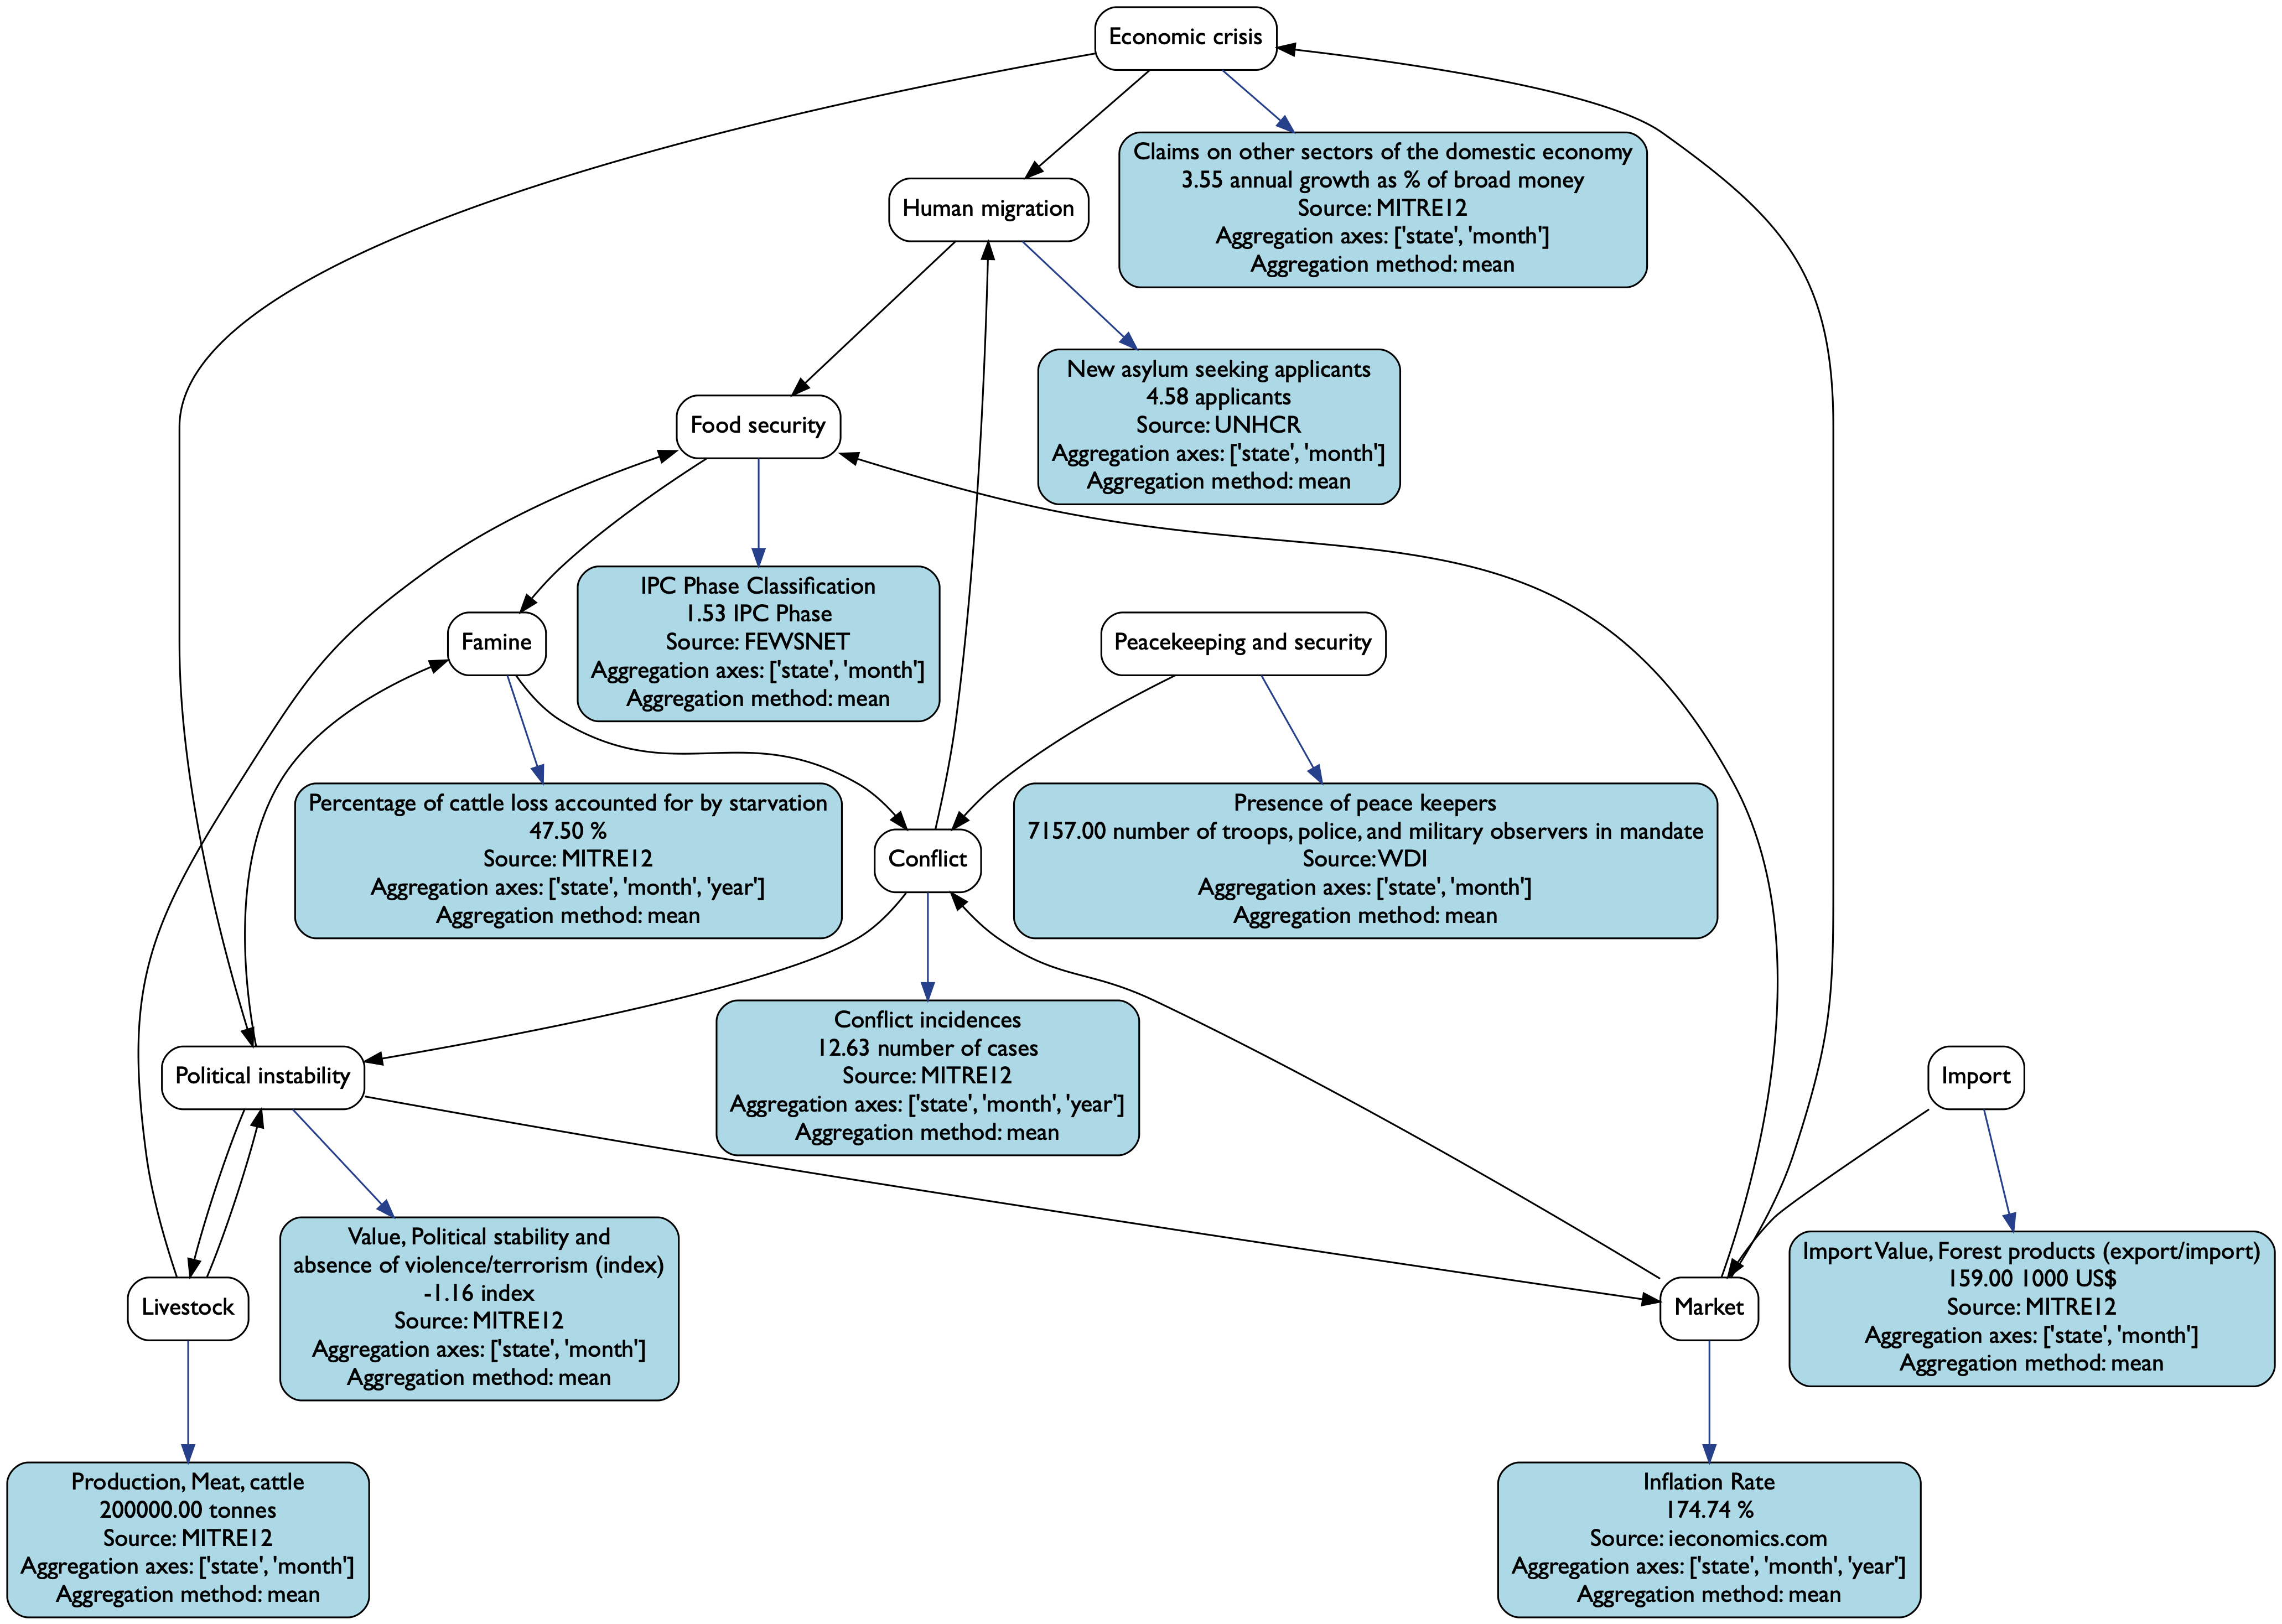

In [6]:
units = {"Claims on other sectors of the domestic economy": "annual growth as % of broad money"}
G.parameterize(year=2012, units=units)
visualize(G, indicators=True, indicator_values=True)

Here we train the inference model for the Casual Analysis Graph. Below you can see that the CAG G is passed to the train_model function. 

Other important arguments are:
- start_year: The initial year to start training from.
- start_month: The initial month to start training from.
- end_year: The ending year for training.
- end_month: The ending month for training. 

The above arguments ensures that the model is trained with the appropriate data given a time range.

The second last argument shown is the the sample resolution (current seen set at 1000, default is 200). 

The last argument passed is a scale parameter for setting the "standard deviation" for a set of data values for each indicator variable given a time range. This affects the standard deviation of predictions. 

The train_model function can also take in all the parameter arguments as parameterize allowing for the setting of country, state, units, etc. 

In [7]:
EN.train_model(G,2015,1,2015,12,1000,50000,k=1)

100%|██████████| 51000/51000 [58:37<00:00, 15.65it/s]  


The next function generates predictions for a given time range. Like train_model this takes a set of arguments start_year, start_month, end_year, and end_month that specify the time range for predictions. 

*Note: The predictions can be heavily reliant of the initial conditions, which are determined by the initial date of the prediction range (i.e, I suspect there is an initial condition bias). It still remains to be tested whether or not starting predictions from the initial training date or starting at the end of the training range yields more accuracte predictions. For example if training from January, 2015 to December, 2015 and we want to get predictions for January, 2016 to December, 2016, is it better to start predicting from January, 2015 or at the start of the dates we want (January, 2016). Initiating predictions at one time step before the prediction range is also a possibility for the most accurate predictions. 

In [8]:
EN.generate_predictions(G,2016,1,2016,12)

Now that the predictions have been generated, there are several options for output. First is the to just return the raw predictions for a given indicator variable in a numpy array. This allows one to do there own plotting and manipulations. 

*Note: True data values from the delphi database can be retrieved using the data_to_df function in evaluation.py. 

In [9]:
EN.pred_to_array(G,'New asylum seeking applicants')

array([[-38.13818409, -39.58551207, -42.2448447 , ..., -42.33434699,
        -39.38807789, -38.40100493],
       [-45.23979801, -37.36692645, -46.24299093, ..., -52.25608615,
        -49.32869882, -42.46396938],
       [-47.47195062, -46.65523829, -43.85264743, ..., -42.89264923,
        -47.02531594, -51.09793318],
       ...,
       [-79.50977077, -73.8843744 , -75.5484263 , ..., -73.62006623,
        -76.46358844, -72.62384056],
       [-82.67837816, -82.09565084, -77.6411729 , ..., -76.29718104,
        -81.52456357, -79.91701549],
       [-83.26334518, -79.70849437, -82.98782065, ..., -85.02083543,
        -80.42769398, -82.32171874]])

The evaluation.py module can also output a pandas dataframe with the mean of the predictions along with a specified confidence interval for a given indicator variable. There are also options for presenting the true values, residuals, and error bounds based off of the residuals. 

*Note: Setting true_vals = True assumes that real data values exist in the database that match the time points of the predictions. Since the data retrieval function is set to return heuristic estimates for missing data values, then it's possible to have completely "made-up" true data if none actually exist for the prediction time range. Also whatever the mean_pred_to_df function should be passed the same country, state, units arguments as train_model (if any were passed). 

In [10]:
EN.mean_pred_to_df(G,'New asylum seeking applicants',true_vals=True)

,New asylum seeking applicants(Mean Prediction),New asylum seeking applicants(Lower Confidence Bound),New asylum seeking applicants(Upper Confidence Bound),New asylum seeking applicants(True),Error,Lower Error Bound,Upper Error Bound
2016-1,-39.985505,-40.169425,-39.801585,10.0,-49.985505,-50.169425,-49.801585
2016-2,-43.659150,-43.845815,-43.472484,17.0,-60.659150,-60.845815,-60.472484
2016-3,-47.573549,-47.753343,-47.393756,13.0,-60.573549,-60.753343,-60.393756
2016-4,-51.647217,-51.829489,-51.464945,17.0,-68.647217,-68.829489,-68.464945
2016-5,-55.363292,-55.550267,-55.176316,9.0,-64.363292,-64.550267,-64.176316
2016-6,-59.467344,-59.657446,-59.277243,16.0,-75.467344,-75.657446,-75.277243
2016-7,-63.410994,-63.595381,-63.226606,22.0,-85.410994,-85.595381,-85.226606
2016-8,-67.226131,-67.404253,-67.048009,33.0,-100.226131,-100.404253,-100.048009
2016-9,-71.288606,-71.468892,-71.108320,19.0,-90.288606,-90.468892,-90.108320
2016-10,-75.141838,-75.332231,-74.951445,18.0,-93.141838,-93.332231,-92.951445


Finally we can get a plots representing the same data shown above. 

The plot types are:
- Prediction: Shows only the predictions with specified confidence intervals. This is the default setting.
- Comparison: Shows the predictions and confidence intervals along with a curve representing the true data values.
- Error: Plots just the error with the error bounds along with a red reference line at 0. 

*Note: The above note for mean_pred_to_df also holds true for the Comparison and Error plot type. Also any other string argument passed to plot_type results in the defaults in the 'Prediction' plot type. The save_as argument can be set to a filename (with extension) to save the plot as a file (e.g, save_as = pred_plot.pdf). 

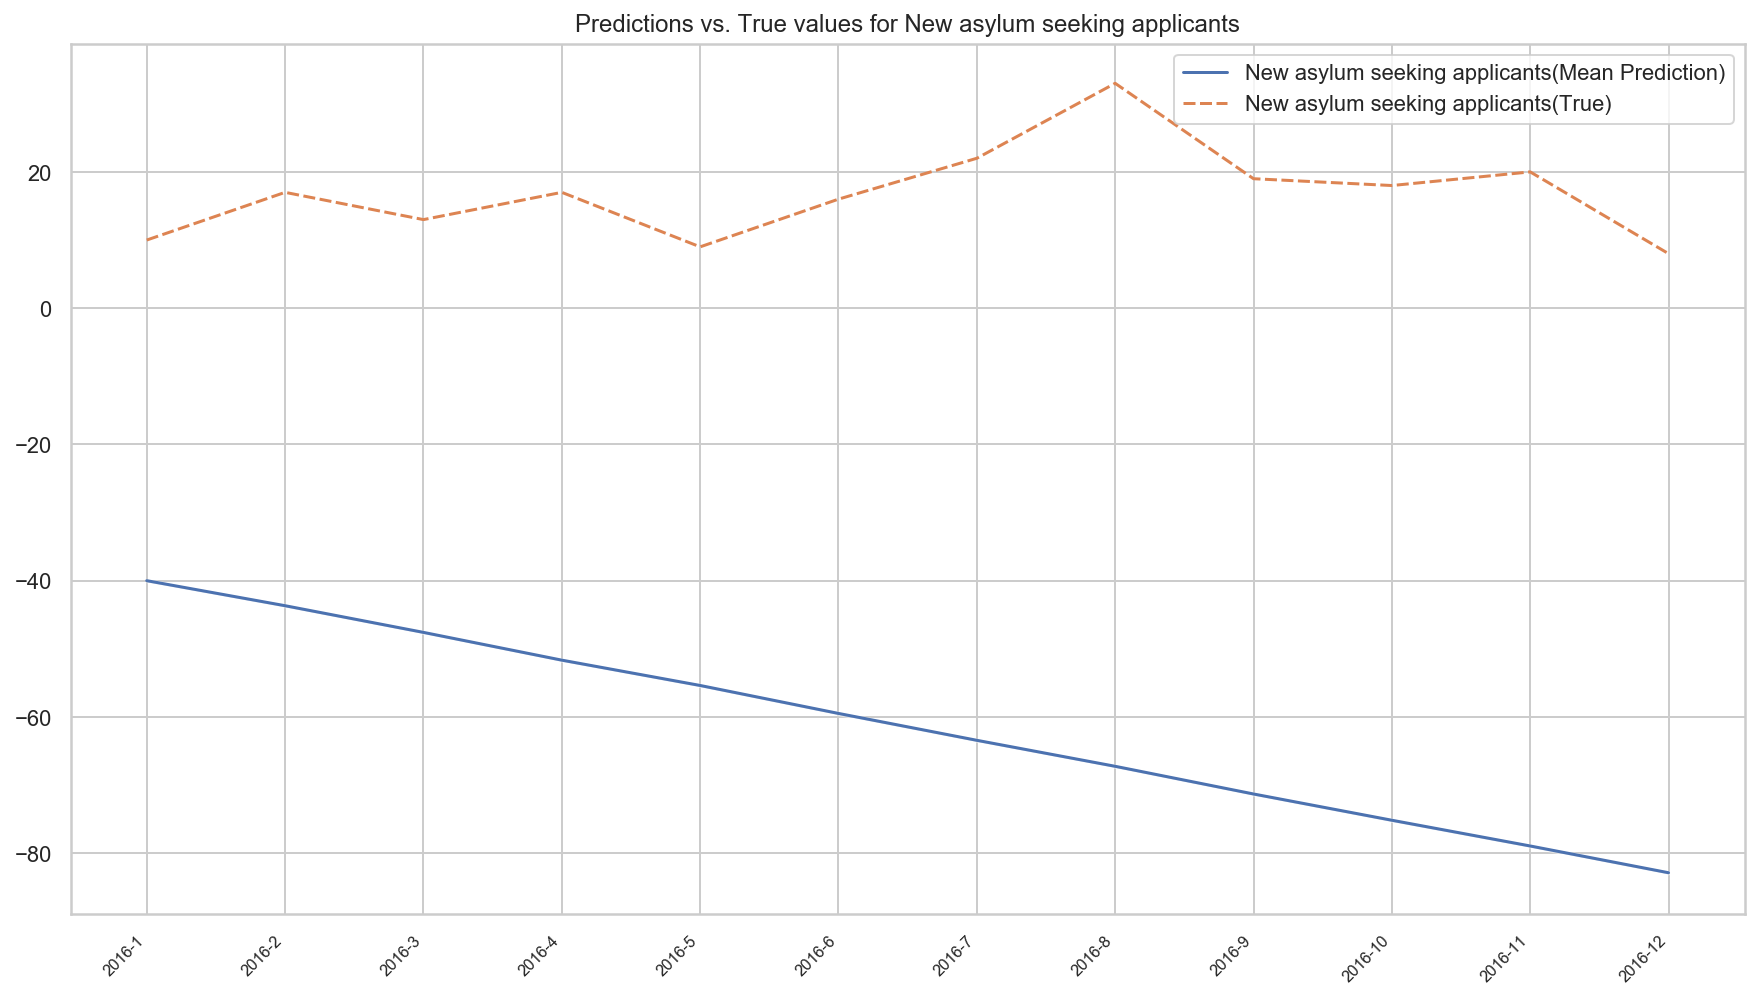

In [11]:
EN.pred_plot(G,'New asylum seeking applicants',plot_type='Comparison',save_as=None)